# **Week 1: Data Preprocessing/Cleaning**
First we import libraries like pandas and numpy to load and process our raw datasets collected from solar plants and sensors. <br>



In [51]:
import pandas as pd
import numpy as np

Now we load and inspect all the raw files (generation and weather datasets for two plants) uploaded in the Github repository using pandas dataframe.

In [52]:
file_gen1 = 'https://raw.githubusercontent.com/imsubhani/Solar-Power-Generation-Predictor/refs/heads/main/data/raw/Plant_1_Generation_Data.csv'
file_weather1 = 'https://raw.githubusercontent.com/imsubhani/Solar-Power-Generation-Predictor/refs/heads/main/data/raw/Plant_1_Weather_Sensor_Data.csv'
file_gen2 = 'https://raw.githubusercontent.com/imsubhani/Solar-Power-Generation-Predictor/refs/heads/main/data/raw/Plant_2_Generation_Data.csv'
file_weather2 = 'https://raw.githubusercontent.com/imsubhani/Solar-Power-Generation-Predictor/refs/heads/main/data/raw/Plant_2_Weather_Sensor_Data.csv'

df_gen1 = pd.read_csv(file_gen1)
df_weather1 = pd.read_csv(file_weather1)
df_gen2 = pd.read_csv(file_gen2)
df_weather2 = pd.read_csv(file_weather2)
print("All 4 files loaded successfully.")

print("\n--- PREVIEW 1: Raw Plant 1 Generation Data (Head) ---")
print(df_gen1.head())
print("\n--- PREVIEW 1: Raw Plant 1 Generation Data (Info) ---")
df_gen1.info()
print("\n--- PREVIEW 2: Raw Plant 1 Weather Data (Head) ---")
print(df_weather1.head())
print("\n--- PREVIEW 2: Raw Plant 1 Weather Data (Info) ---")
df_weather1.info()

print("\n--- PREVIEW 3: Raw Plant 2 Generation Data (Head) ---")
print(df_gen2.head())
print("\n--- PREVIEW 3: Raw Plant 2 Generation Data (Info) ---")
df_gen2.info()
print("\n--- PREVIEW 4: Raw Plant 2 Weather Data (Head) ---")
print(df_weather2.head())
print("\n--- PREVIEW 4: Raw Plant 2 Weather Data (Info) ---")
df_weather2.info()

All 4 files loaded successfully.

--- PREVIEW 1: Raw Plant 1 Generation Data (Head) ---
          DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4  15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  
4          0.0    7158964.0  

--- PREVIEW 1: Raw Plant 1 Generation Data (Info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     6877

**ANALYSIS OF PREVIEWS**
1.   **DATE_TIME Mismatch:** <br> Plant 1 Generation is 'dd-mm-YYYY'. The other three are 'YYYY-mm-dd'.
2.   **Row Count Mismatch:** <br> Generation files have ~68k rows. Weather files have ~3k rows. *This is because Generation data is "per inverter" (SOURCE_KEY) and must be aggregated.*


## Data Cleaning and Merging Function
Cleans, aggregates, and merges generation and weather data for one plant.
1. **Standardize DATE_TIME columns**<br>Weather data is in a standard format. Generation data needs a specific format string.
2. **Aggregate Generation Data**<br>We sum the power from all inverters (SOURCE_KEY) at each timestamp
3. **Merge Aggregated Generation with Weather Data**<br>We only keep timestamps where we have BOTH weather and power data (how='inner')
4. **Drop columns we no longer need**<br>PLANT_ID and SOURCE_KEY are no longer needed after merging

In [53]:
def process_plant_data(gen_df, weather_df, gen_date_format):

    weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'])
    gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'], format=gen_date_format)

    gen_agg = gen_df.groupby('DATE_TIME').agg(
        DC_POWER_SUM=('DC_POWER', 'sum'),
        AC_POWER_SUM=('AC_POWER', 'sum'),
        DAILY_YIELD_AVG=('DAILY_YIELD', 'mean')
    ).reset_index()

    df_merged = pd.merge(gen_agg, weather_df, on='DATE_TIME', how='inner')

    df_merged = df_merged.drop(columns=['PLANT_ID', 'SOURCE_KEY'], errors='ignore')

    return df_merged

In [54]:
df_plant1 = process_plant_data(df_gen1, df_weather1, gen_date_format='%d-%m-%Y %H:%M')
df_plant2 = process_plant_data(df_gen2, df_weather2, gen_date_format='%Y-%m-%d %H:%M:%S')

print("Plant 1 data processed and merged.")
print("Plant 2 data processed and merged.")

print("\n--- PREVIEW 5: Plant 1 Merged & Aggregated Data ---")
print(df_plant1.head())
print(f"Total rows: {len(df_plant1)}")

print("\n--- PREVIEW 6: Plant 2 Merged & Aggregated Data ---")
print(df_plant2.head())
print(f"Total rows: {len(df_plant2)}")

Plant 1 data processed and merged.
Plant 2 data processed and merged.

--- PREVIEW 5: Plant 1 Merged & Aggregated Data ---
            DATE_TIME  DC_POWER_SUM  AC_POWER_SUM  DAILY_YIELD_AVG  \
0 2020-05-15 00:00:00           0.0           0.0              0.0   
1 2020-05-15 00:15:00           0.0           0.0              0.0   
2 2020-05-15 00:30:00           0.0           0.0              0.0   
3 2020-05-15 00:45:00           0.0           0.0              0.0   
4 2020-05-15 01:00:00           0.0           0.0              0.0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
0            25.184316           22.857507          0.0  
1            25.084589           22.761668          0.0  
2            24.935753           22.592306          0.0  
3            24.846130           22.360852          0.0  
4            24.621525           22.165423          0.0  
Total rows: 3157

--- PREVIEW 6: Plant 2 Merged & Aggregated Data ---
            DATE_TIME  DC_POWER_SUM  A

##Combine Datasets and Final Cleaning
Combine both plants into one master DataFrame.<br>Filter out nighttime/zero-power data. A model trained on 0s is not useful.

In [55]:
final_df = pd.concat([df_plant1, df_plant2], ignore_index=True)

print("\n--- PREVIEW 7: Combined Master Data (Before Filtering) ---")
print(final_df.head())
print(f"Total rows from both plants: {len(final_df)}")

# We only want to predict power when there's sun.
df_daytime = final_df[
    (final_df['IRRADIATION'] > 0.01) &
    (final_df['AC_POWER_SUM'] > 1)
].copy()

# Check for any remaining null values just in case
df_daytime = df_daytime.dropna()

print(f"\n--- Data Filtering ---")
print(f"Original merged data: {len(final_df)} rows")
print(f"Filtered daytime data: {len(df_daytime)} rows")

print("\n--- PREVIEW 8: Final Daytime-Only Data ---")
print(df_daytime.head())


--- PREVIEW 7: Combined Master Data (Before Filtering) ---
            DATE_TIME  DC_POWER_SUM  AC_POWER_SUM  DAILY_YIELD_AVG  \
0 2020-05-15 00:00:00           0.0           0.0              0.0   
1 2020-05-15 00:15:00           0.0           0.0              0.0   
2 2020-05-15 00:30:00           0.0           0.0              0.0   
3 2020-05-15 00:45:00           0.0           0.0              0.0   
4 2020-05-15 01:00:00           0.0           0.0              0.0   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
0            25.184316           22.857507          0.0  
1            25.084589           22.761668          0.0  
2            24.935753           22.592306          0.0  
3            24.846130           22.360852          0.0  
4            24.621525           22.165423          0.0  
Total rows from both plants: 6416

--- Data Filtering ---
Original merged data: 6416 rows
Filtered daytime data: 3301 rows

--- PREVIEW 8: Final Daytime-Only Data ---
    

## Save the Preprocessed Data

In [56]:
preprocessed_file = 'solar_master_preprocessed.csv'
df_daytime.to_csv(preprocessed_file, index=False)

# **Week 2: Data Analysis, Model Training, Prediction**

Import the new libraries I need for analysis and modeling.

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

sns.set(style="whitegrid")

## Correlation Analysis (EDA)
We'll use a heatmap to find which weather features are most correlated with our target, AC_POWER_SUM.<br><br>
To prevent data leakage, DC_POWER_SUM and DAILY_YIELD_AVG are removed since they aren't predictive weather features, and are target-related.

--- Correlation with AC_POWER_SUM ---
AC_POWER_SUM           1.000000
IRRADIATION            0.871901
MODULE_TEMPERATURE     0.810962
AMBIENT_TEMPERATURE    0.363366
Name: AC_POWER_SUM, dtype: float64


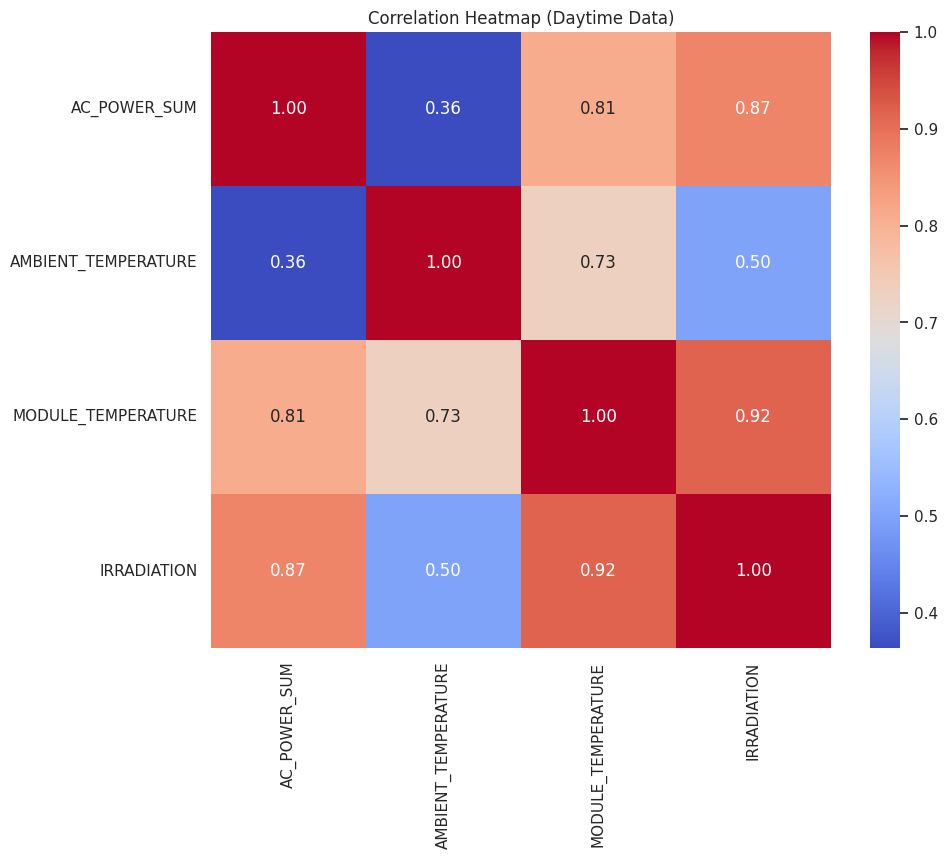

In [65]:
eda_df = df_daytime.drop(columns=['DC_POWER_SUM', 'DAILY_YIELD_AVG'])

corr_matrix = eda_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Daytime Data)')
plt.savefig('correlation_heatmap.png')

print("--- Correlation with AC_POWER_SUM ---")
print(corr_matrix['AC_POWER_SUM'].sort_values(ascending=False))

**ANALYSIS**<br>
The heatmap clearly shows IRRADIATION (0.87), MODULE_TEMPERATURE (0.81), and AMBIENT_TEMPERATURE (0.36) are strong weather-based predictors. We will use these three features.

## Spliting Data and Scaling Features

In [59]:
top_features = ['IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']
y = df_daytime['AC_POWER_SUM']
X = df_daytime[top_features]
print(f"Features (X): {list(X.columns)}")

# Split Data into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Feature scaling complete.")

Features (X): ['IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']
Training set size: 2640 samples
Test set size: 661 samples
Feature scaling complete.


## Linear Regression (Baseline Attempt)
Let's first try a simple Linear Regression model as our baseline. It will try to fit a straight line to the data.

In [60]:
model_linear = LinearRegression()
model_linear.fit(X_train_scaled, y_train)

# Model Evaluation
y_pred_linear = model_linear.predict(X_test_scaled)
r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
y_mean = y_test.mean()
error_percent_linear = (mae_linear / y_mean) * 100

print("Linear Regression Results")
print(f"R-squared: {r2_linear:.4f} (Model explains {r2_linear*100:.1f}% of variation)")
print(f"Mean Absolute Error (MAE): {mae_linear:.2f} kW ({error_percent_linear:.2f}% of mean power)")

Linear Regression Results
R-squared: 0.7935 (Model explains 79.3% of variation)
Mean Absolute Error (MAE): 2311.66 kW (20.61% of mean power)


**ANALYSIS**: The Linear Regression model gives an $R^2$ of ~0.79<br>
**CONCLUSION**: A simple linear model is not a good fit. We need a model that can capture the non-linear relationship.

## Polynomial Regression (Improved Model)
Based on our analysis, we will create 2nd-degree polynomial features.

In [61]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"New number of polynomial features: {X_train_poly.shape[1]}")

Original number of features: 3
New number of polynomial features: 9


## Training model with new polynomial features

In [62]:
# Improved Model
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Model Evaluation
y_pred_poly = model_poly.predict(X_test_poly)
r2_poly = r2_score(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
error_percent_poly = (mae_poly / y_mean) * 100

print("Polynomial Regression Results")
print(f"R-squared: {r2_poly:.4f} (Model explains {r2_poly*100:.1f}% of variation)")
print(f"Mean Absolute Error (MAE): {mae_poly:.2f} kW ({error_percent_poly:.2f}% of mean power)")

Polynomial Regression Results
R-squared: 0.8495 (Model explains 84.9% of variation)
Mean Absolute Error (MAE): 1742.03 kW (15.53% of mean power)


The Polynomial model is significantly better. Its $R^2$ is much higher, showing it fits the data properly, and its error (MAE) is less than half of the baseline model.

Metric              | Baseline (Linear) | Improved (Polynomial)
--------------------|-------------------|----------------------
R-squared           | 0.7935            | 0.8495
Mean Absolute Error | 2311.66 kW        | 1742.03 kW

##Final Model Visualization

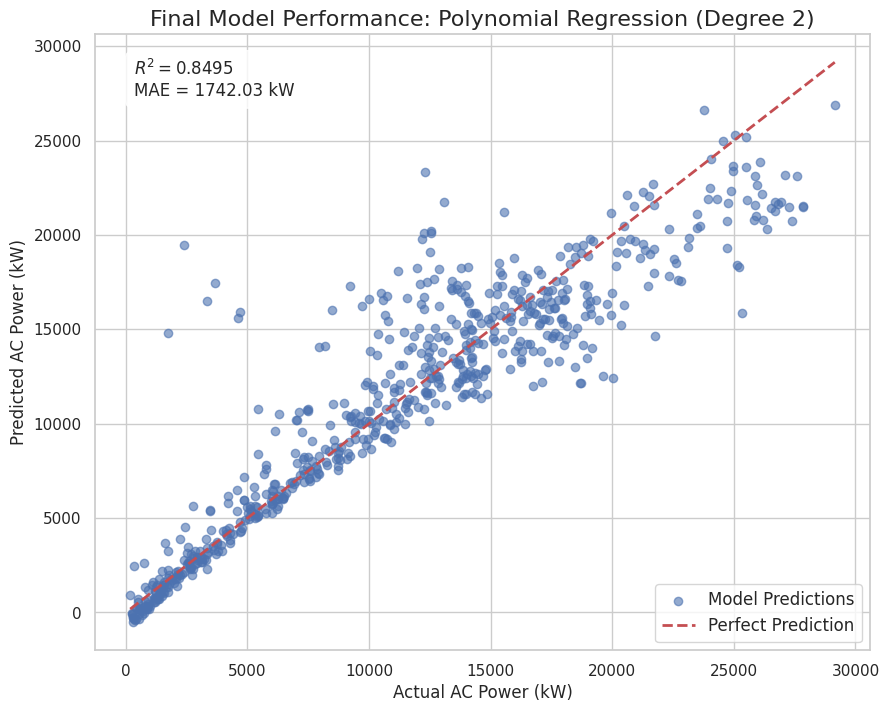

In [63]:
# Actual vs. Predicted

plt.figure(figsize=(10, 8))

plt.scatter(y_test, y_pred_poly, alpha=0.6, label='Model Predictions')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')

plt.title(f'Final Model Performance: Polynomial Regression (Degree 2)', fontsize=16)
plt.xlabel('Actual AC Power (kW)', fontsize=12)
plt.ylabel('Predicted AC Power (kW)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.text(0.05, 0.9, f'$R^2 = {r2_poly:.4f}$\nMAE = {mae_poly:.2f} kW',
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

plt.savefig('final_model_performance.png')
plt.show()

By identifying the non-linear relationships and using polynomial feature engineering, we were able to create a much more accurate and reliable model to predict AC power generated in a 15 minute block under a given set of conditions (input features).